# The Metropolis Algorithm - Lattice scalar theory in 0D

## Motivation

In the previous exercise, the Monte Carlo integration method was introduced and applied to obtain an estimate of $\pi$.\
The algorithm consisted of:
1. Generating uniformly-distributed values for the variables of integration: the points $(x, y)$ in
the plane were uniformly sampled from the region $\Omega = [-1, 1] \times [-1, 1]$.
2. Evaluating the integrand at these points.
3. Averaging the values of the integrand and multiplying by the volume of the domain.

What if we wanted to solve numerically the following integral(s)?
\begin{equation}
    \int\limits_{-\infty}^{\infty} \mathrm{d}x \; x^{n} \, \frac{\mathrm{e}^{-x^{2}}}{Z}, \quad n \geq 0, \quad Z := \int\limits_{-\infty}^{\infty} \mathrm{d}x \; \mathrm{e}^{-x^{2}}.
\end{equation}
Here, some shortcomings of the previous method become apparent:
* We can't uniformly sample the variable of integration $x$.
Or we must truncate at some point.
* If we do not know $Z$, how can we evaluate the integrand in order to sum its values?
(Or, is it _necessary_ to compute $Z$ first and then try to compute the rest?)

Although the integral of a Gaussian and its moments are something that you know how to solve analytically, this example already resembles the integrals in lattice field theory.

For example, for a scalar field $\phi$ in the lattice, the average of some operator $O[\phi]$ is given by
\begin{equation}
    \langle O \rangle = \int \prod_{n \in \Lambda} \mathrm{d}\phi(n) \; O[\phi] \, \frac{\mathrm{e}^{-S[\phi]}}{Z},
\end{equation}
where $n \in \Lambda$ denotes spacetime points in the lattice $\Lambda$, $S[\phi]$ denotes the discretized (Euclidean) action of the theory, and
\begin{equation}
    Z = \int \prod_{n \in \Lambda} \mathrm{d}\phi(n) \; \mathrm{e}^{-S[\phi]}.
\end{equation}

Hence, writing the above Gaussian integrals as
\begin{equation}
    \langle \phi^{n} \rangle = \int\limits_{-\infty}^{\infty} \mathrm{d}\phi \; \phi^{n} \, \frac{\mathrm{e}^{-\phi^{2}}}{Z}, \qquad Z = \int\limits_{-\infty}^{\infty} \mathrm{d}\phi \; \mathrm{e}^{-\phi^{2}},
\end{equation}
we see that, from the perspective of Lattice Field Theory:
* we have a lattice of a single spacetime point (0-dimensional), with a real scalar field $\phi$ at that point,
* the action of the theory is $S[\phi] = \phi^{2}$, and
* our operators of interest are $\phi^{n}$.

## The Algorithm

The Metropolis algorithm aims to sample a _target distribution_ $P(\phi)$ for which direct sampling is not possible.

It belongs to a class of algorithms called **Markov chain Monte Carlo** (MCMC). \
In short, these algorithms build a sequence of values for the field or “states”, $\{ \phi_{0}, \phi_{1}, \dots \}$, where each $\phi_{i + 1}$ is obtained only from the immediate previous one $\phi_{i}$ (this is the Markov chain) through a random modification of it (this is the Monte Carlo).

Under a few conditions, this method is guaranteed to _asymptotically_ sample $P(\phi)$. \
(We won't go into the details, but feel free to ask for references)

For this algorithm we need:
* An initial state $\phi_{0}$, i.e., a value in the domain of integration.
* To evaluate $P(\phi)$ _up to a constant_. No need to know $Z$! (since the constant C cancels out in $P_{\text{acc}}$)
* A (symmetric) proposal function $g(\phi' | \phi)$, i.e., a function that proposes a value $\phi'$ based on $\phi$ satisfying $g(\phi' | \phi) = g(\phi | \phi')$.

Then, the steps of the algorithm are:
1. Propose a value $\phi'$ from $g(\phi' | \phi_{i})$.
2. Compute the acceptance probability
\begin{equation}
    P_{\text{acc}}(\phi', \phi_{i}) = \text{min}\left(1, \frac{P(\phi')}{P(\phi)} \right).
\end{equation}
3. Accept or reject: Generate a uniform random number $r \in [0, 1)$ and
    1. If $r \leq P_{\text{acc}}(\phi', \phi_{i})$, _accept_ the proposal: $\phi_{i + 1} = \phi'$.
   2. Else, _reject_ the proposal: $\phi_{i + 1} = \phi_{i}$.

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np


def compute_action(phi: float) -> float:
    return phi ** 2


def propose_phi(phi: float,
                width: float,
                rng: np.random.Generator) -> float:
    delta = 2 * rng.random() - 1  # Random number between -1 and 1.
    return phi + width * delta


def metropolis_step(phi: float, width: float, rng: np.random.Generator):
    # 1. Proposal
    proposed_phi = propose_phi(phi, width, rng)

    # 2. Acceptance probability.
    current_action = compute_action(phi)
    proposed_action = compute_action(proposed_phi)
    p_acceptance = min(1, np.exp(current_action - proposed_action))

    # 3. Accept/reject
    r = rng.random()

    if r <= p_acceptance:  # Accept.
        return proposed_phi, 1

    # Reject.
    return phi, 0


def sample_field(initial_phi: float,
                 num_samples: int,
                 width: float,
                 rng: np.random.Generator):
    chain = []
    acceptance = []

    chain.append(initial_phi)

    for idx in range(num_samples):
        phi, accepted = metropolis_step(phi=chain[-1], width=width, rng=rng)
        chain.append(phi)
        acceptance.append(accepted)

    return chain, acceptance

## Visualizing the Markov Chain

In [2]:
def view_method(initial_phi: float,
                num_samples: int,
                width: float,
                rng: np.random.Generator):
    proposals = np.zeros(num_samples)
    acceptance = np.zeros(num_samples, dtype=bool)

    current_phi = initial_phi
    current_action = compute_action(current_phi)

    for idx in range(num_samples):
        proposed_phi = propose_phi(current_phi, width, rng)
        proposed_action = compute_action(proposed_phi)

        diff_action = current_action - proposed_action

        proposals[idx] = proposed_phi

        if diff_action > 0 or np.exp(diff_action) > rng.random():
            # Proposed configuration was accepted.
            current_phi = proposed_phi
            current_action = proposed_action
            acceptance[idx] = True

    chain = np.zeros(num_samples + 1)
    chain[0] = initial_phi
    chain[1:] = proposals.copy()
    
    rejected = np.argwhere(acceptance == 0).flatten()
    for idx in rejected:
        chain[1 + idx] = chain[idx]

    x_rejected = [int(idx) + 1 for idx in rejected]
    y_rejected = proposals[acceptance == 0]

    return x_rejected, y_rejected, chain

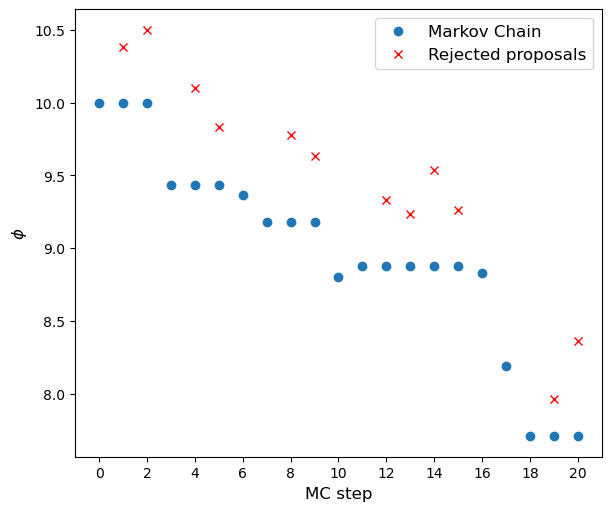

In [3]:
x_r, y_r, mc = view_method(initial_phi=10.0, num_samples=20, width=0.7, rng=np.random.default_rng(seed=42))
fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
ax.plot(mc, 'o', label="Markov Chain")
ax.plot(x_r, y_r, 'x', color='r', label="Rejected proposals")
ax.set_xticks(range(0, len(mc) + 1, 2))
ax.set_xlabel("MC step", fontsize=12)
ax.set_ylabel(r'$\phi$', fontsize=12)
ax.legend(fontsize=12)
plt.show()

### Questions

1. For a target distribution $P(\phi) \propto \mathrm{e}^{-S[\phi]}$, the acceptance probability reads
\begin{equation}
    P_{\text{acc}}(\phi', \phi) = \text{min}\left(1, \mathrm{e}^{-\Delta S} \right), \qquad \Delta S = S[\phi'] - S[\phi].
\end{equation}
What does this imply for proposals with $\Delta S \leq 0$?
2. Show that the proposal function used above is indeed symmetric, i.e., $g(\phi' | \phi_{i}) = g(\phi_{i} | \phi')$.
3. In the above implementation of the Metropolis algorithm, there is a quantity that is being computed twice. Which one is it?

## Answers

1. If $\Delta S \leq 0$, then $e^{-\Delta S} \geq 1$ and then $\min(1, e^{-\Delta S}) = 1$. The proposal is accepted with probability = 1.  
2. The proposal function is defined as follows: 
\begin{equation}
    g(\phi'|\phi_i) = \phi_i + w \cdot \delta, \delta \in [-1, 1] = g(\phi_i|\phi')
\end{equation}
This is since the interval [-1,1] is symmetric around zero and delta is a random value from that interval. It does not matter whether I compare before to after or vice versa. 
3. The current and proposed action are the same quantity in between two steps. It would be better to keep track of the actions and reuse in the next step. 

In [4]:
phi_samples, acceptances = sample_field(initial_phi=10.0,
                                        num_samples=1_000,
                                        width=0.7,
                                        rng=np.random.default_rng(seed=42))
print(f"Acceptance rate: {np.mean(acceptances) * 100:.2f}%")

Acceptance rate: 78.40%


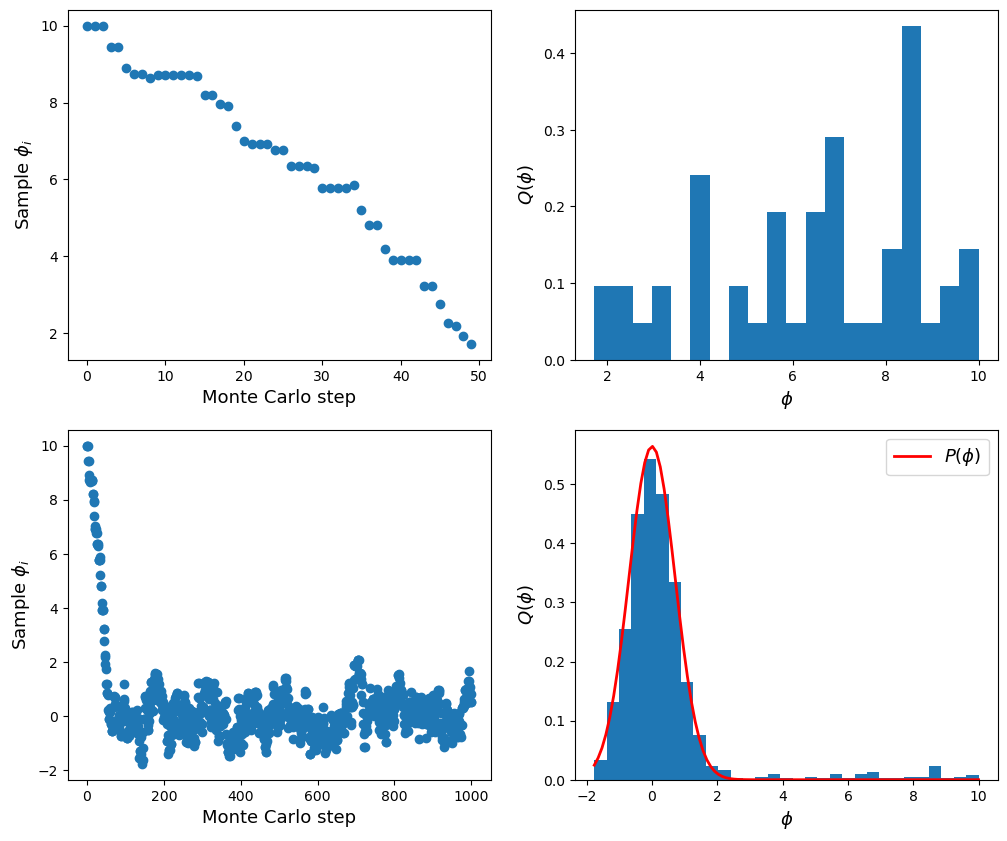

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# The sample $\phi_i$ decreases more of less monotonically
axes[0, 0].plot(phi_samples[:50], 'o')
axes[0, 0].set_xlabel("Monte Carlo step", fontsize=13)
axes[0, 0].set_ylabel(r"Sample $\phi_{i}$", fontsize=13)

#We are trying to sample a Gaussian, that is not visible for only 50 samples
axes[0, 1].hist(phi_samples[:50], bins=20, density=True)
axes[0, 1].set_xlabel(r"$\phi$", fontsize=13)
axes[0, 1].set_ylabel(r"$Q(\phi)$", fontsize=13)

#same, but with more samples. We start to converge. 
axes[1, 0].plot(phi_samples, 'o')
axes[1, 0].set_xlabel("Monte Carlo step", fontsize=13)
axes[1, 0].set_ylabel(r"Sample $\phi_{i}$", fontsize=13)

#We are now able to approximate the Gaussian. 
#This chain has a long tail above the target distribution, undesirable, we use thermalization.
phi_range = np.linspace(min(phi_samples), max(phi_samples), 100)
axes[1, 1].hist(phi_samples, bins=31, density=True)
axes[1, 1].plot(phi_range, np.exp(-(phi_range ** 2)) / np.sqrt(np.pi), color='red', linewidth=2, label=r"$P(\phi)$")
axes[1, 1].set_xlabel(r"$\phi$", fontsize=13)
axes[1, 1].set_ylabel(r"$Q(\phi)$", fontsize=13)
axes[1, 1].legend(fontsize=13)
plt.show()

## Thermalization

In obtaining the above chain we used $\phi_{0} = 10.0$ as our initial state.\
Although this value for $\phi$ is allowed (i.e., it is in the domain of integration), it is quite unlikely, and as a result our finite chain has some bias.\
This can be seen in the plots of the chain and the distribution, where the chain starts at 10 and decreases towards values roughly between -2 and 2, where it fluctuates.\
This trend of initial decrease (or increase) until the chain “settles” is known as _thermalization_.\
Hence, in order to reduce the bias introduced by taking an unlikely initial state, we discard values from the beginning of the chain.

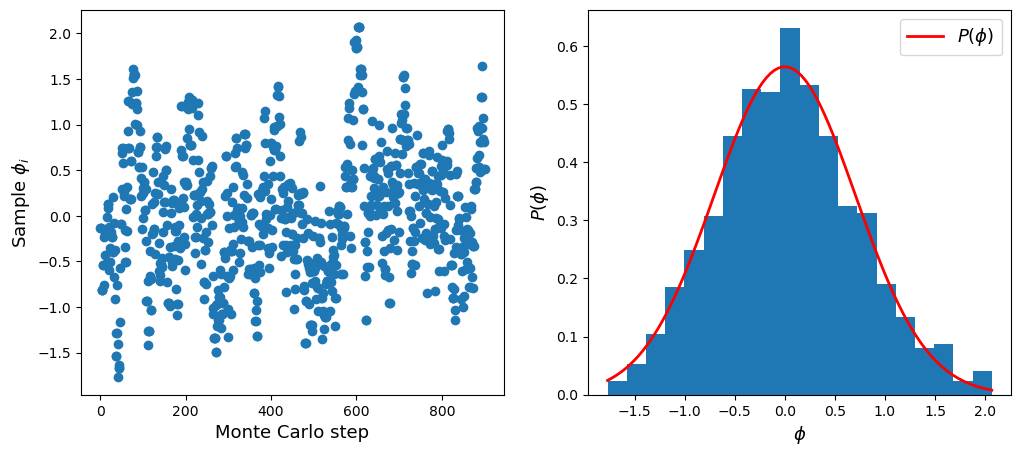

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
phi_t_samples = phi_samples[100:]
axes[0].plot(phi_t_samples, 'o')
axes[0].set_xlabel("Monte Carlo step", fontsize=13)
axes[0].set_ylabel(r"Sample $\phi_{i}$", fontsize=13)

phi_t_range = np.linspace(min(phi_t_samples), max(phi_t_samples), 100)
axes[1].hist(phi_t_samples, bins=20, density=True)
axes[1].plot(phi_t_range, np.exp(-(phi_t_range ** 2)) / np.sqrt(np.pi), color='red', linewidth=2, label=r"$P(\phi)$")
axes[1].set_xlabel(r"$\phi$", fontsize=13)
axes[1].set_ylabel(r"$P(\phi)$", fontsize=13)
axes[1].legend(fontsize=13)
plt.show()

### Questions

1. Assuming 1,000 i.i.d. samples drawn from $P(\phi) = \mathrm{e}^{-\phi^2} / \sqrt{\pi} $, what is the probability that at least one of them is $\lvert \phi \rvert \geq 5$?
2. What could be a better initial state for generating the Markov chain?

In [9]:
print(np.exp(-5**2)/np.sqrt(np.pi))

7.835433265508668e-12


## Answers  
1. Very very small. 7.835433265508668e-12
2. Center of the distribution, e.g. zero. 

## Role of the width

Our proposal function has a (hyper-)parameter, the width, which establishes the maximum distance our new proposal $\phi'$ can be from the current state $\phi_{i}$.\
Since this is an input for the theory, we need to investigate what effect does it have in building the Markov chain.

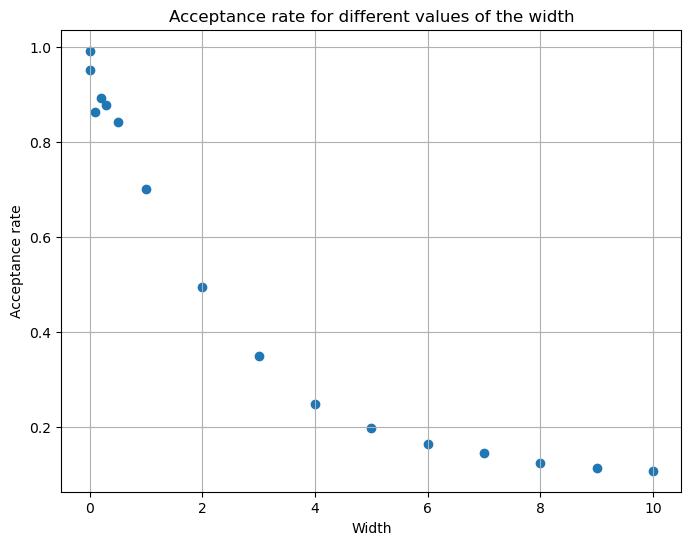

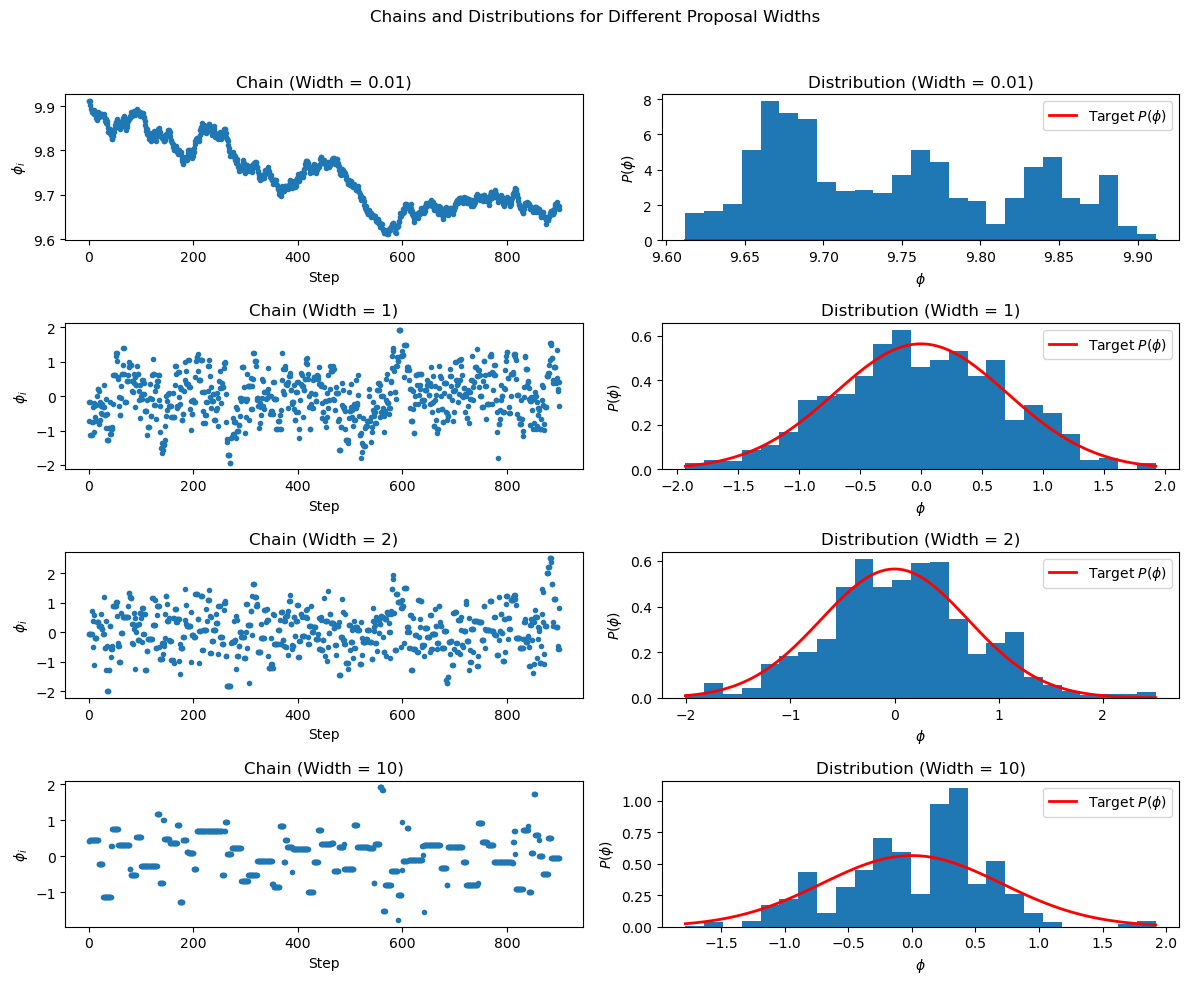

In [26]:
# TODO: Plot the acceptance rate for different values of the width.
widths = [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

acc_vals = []
for w in widths: 
    phi_samples, acceptances = sample_field(initial_phi=10.0,
                                        num_samples=1_000,
                                        width=w,
                                        rng=np.random.default_rng(seed=42))
    acc_vals.append(acceptances)

plt.figure(figsize=(8, 6))
plt.scatter(widths, [np.mean(acc) for acc in acc_vals])
plt.grid(True)
plt.title("Acceptance rate for different values of the width")
plt.xlabel("Width")
plt.ylabel("Acceptance rate")

# TODO: Plot the chains and distributions for 3 different acceptance rates (e.g., ~99%, ~75%, ~50%).
chosen_widths = [0.01, 1, 2, 10]  # ~99%, ~75%, ~50%
labels = [f"Width = {w}" for w in chosen_widths]

fig, axs = plt.subplots(nrows=len(chosen_widths), ncols=2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
fig.suptitle("Chains and Distributions for Different Proposal Widths")

for i, (w, label) in enumerate(zip(chosen_widths, labels)):
    phi_samples, acceptances = sample_field(initial_phi=10.0,
                                            num_samples=1_000,
                                            width=w,
                                            rng=np.random.default_rng(seed=42))

    phi_t_samples = phi_samples[100:]

    axs[i, 0].plot(phi_t_samples, 'o', markersize=3)
    axs[i, 0].set_title(f"Chain ({label})")
    axs[i, 0].set_xlabel("Step")
    axs[i, 0].set_ylabel(r"$\phi_i$")

    phi_t_range = np.linspace(min(phi_t_samples), max(phi_t_samples), 100)
    axs[i, 1].hist(phi_t_samples, bins=25, density=True)
    axs[i, 1].plot(phi_t_range,
                  np.exp(-(phi_t_range ** 2)) / np.sqrt(np.pi),
                  color='red', linewidth=2,
                  label=r"Target $P(\phi)$")
    axs[i, 1].set_title(f"Distribution ({label})")
    axs[i, 1].set_xlabel(r"$\phi$")
    axs[i, 1].set_ylabel(r"$P(\phi)$")
    axs[i, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Is a high acceptance rate necessarily better?  
### Advantages: 
-When the acceptance rate is very low, the convergence is also very slow as consecutive samples are highly correlated and do not well explore the parameter space. The number of independent samples will be underestimated.
### Disadvantages: 
-A acceptance rate close to 100% means that the algorithm only takes very small steps and hence converges slowly or is more likely to converge to a local minimum. Also the steps are more closely correlated, which makes convergence slower. 

#### Fun fact

With this method we are, effectively, drawing samples from a Gaussian distribution.\
However, since this distribution is so ubiquitous for many areas in science, specific algorithms have been developed for sampling it.\
Two interesting examples are:
* The Box-Muller transform, which using a change of variables maps samples from a uniform distribution to a Gaussian one.
* The [Ziggurat algorithm](https://en.wikipedia.org/wiki/Ziggurat_algorithm), which is what NumPy's `np.random.normal()` uses ([see here](https://github.com/numpy/numpy/blob/main/numpy/random/src/distributions/ziggurat_constants.h)).